# **Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [7]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

zsh:1: no matches found: gymnasium[box2d]


### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [ ]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [8]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

In [3]:
# # Ejemplos
# print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
# print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(np.int64(10), np.int64(1), np.int64(10), np.int64(10), np.int64(10), np.int64(10), 1, 1)
(np.int64(10), np.int64(19), np.int64(10), np.int64(10), np.int64(10), np.int64(10), 0, 0)


## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [9]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [10]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [11]:
def ejecutar_episodio(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env

    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [12]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -213.66928256399856 de recompensa, en promedio


### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [64]:
class AgenteRL(Agente):
    def __init__(self, bins, max_accion, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995) -> None:
        super().__init__()
        self.gamma = gamma
        self.epsilon = epsilon  # Factor de exploración
        self.epsilon_min = epsilon_min  # Mínimo valor de epsilon para la política epsilon-greedy
        self.epsilon_decay = epsilon_decay  # Decaimiento de epsilon para disminuir exploración
        self.bins = bins
        self.max_accion = max_accion
        self.q_table = {}  # Tabla Q para almacenar los valores Q de los estados y acciones

    def _discretize_state(self, state):
        """Discretiza el estado continuo en una tupla de indices discretos"""

        state_disc = list()
        for i in range(len(state)):
            if i >= len(self.bins):
                state_disc.append(int(state[i]))
            else:
                state_disc.append(np.digitize(state[i], self.bins[i]))
        return tuple(state_disc)

    def elegir_accion(self, estado, max_accion, explorar=True) -> int:
        """Elige una acción usando la política epsilon-greedy."""

        estado = self._discretize_state(estado)

        if explorar and np.random.rand() < self.epsilon:  # Política epsilon-greedy
            return random.randint(0, max_accion - 1)  # Acción aleatoria
        else:
            if estado not in self.q_table:
                self.q_table[estado] = np.zeros(max_accion)  # Inicializa con ceros si no existe
            return np.argmax(self.q_table[estado])  # Acción óptima

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Actualiza la tabla Q usando la fórmula de Q-learning."""

        estado_anterior = self._discretize_state(estado_anterior)
        estado_siguiente = self._discretize_state(estado_siguiente)
        if estado_anterior not in self.q_table:
            self.q_table[estado_anterior] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe
        if estado_siguiente not in self.q_table:
            self.q_table[estado_siguiente] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe

        max_q_siguiente = np.max(self.q_table[estado_siguiente]) if estado_siguiente in self.q_table else 0
        q_valor_actual = recompensa + self.gamma * max_q_siguiente * (1 - terminado)
        self.q_table[estado_anterior][accion] = q_valor_actual

    def fin_episodio(self):
        """Reduce epsilon para disminuir la exploración en episodios futuros."""

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [41]:
def ejecutar_episodio(agente, aprender = True, render = None):
  entorno = gym.make('LunarLander-v2', render_mode=render).env
  recompensa_total = 0
  termino = False
  truncado = False
  estado_anterior, info = entorno.reset()

  while not termino and not truncado:
      # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
      accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)

      # Realizamos la accion
      estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)

      if (aprender):
          agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

      agente.fin_episodio()
      estado_anterior = estado_siguiente
      recompensa_total += recompensa
  entorno.close()
  return recompensa_total

Y ejecutar con el muchos episodios:

In [66]:
agente = AgenteRL(bins, env.action_space.n)
exitos = 0
recompensa_episodios_aprendiendo = []
num_episodios_aprendiendo = 1000
for i in range(num_episodios_aprendiendo):
    recompensa = ejecutar_episodio(agente, aprender = True)

    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1

    recompensa_episodios_aprendiendo += [recompensa]
print(f"Tasa de éxito APRENDIENDO: {exitos / num_episodios_aprendiendo}. Se obtuvo {np.mean(recompensa_episodios_aprendiendo)} de recompensa, en promedio")

recompensa_episodios_explotando = []
num_episodios_explotando = 1000

for i in range(num_episodios_explotando):
    recompensa = ejecutar_episodio(agente, aprender = False)

    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1

    recompensa_episodios_explotando += [recompensa]
print(f"Tasa de éxito EXPLOTANDO: {exitos / num_episodios_explotando}. Se obtuvo {np.mean(recompensa_episodios_explotando)} de recompensa, en promedio")


Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -110.53862659644496 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.011. Se obtuvo -86.40665071683235 de recompensa, en promedio


## epsilon_min = 0.001
Tasa de éxito APRENDIENDO: 0.004. Se obtuvo -104.31968581897758 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.009. Se obtuvo -108.91409492368417 de recompensa, en promedio

## epsilon_min = 0.01
Tasa de éxito APRENDIENDO: 0.008. Se obtuvo -91.3373685148693 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.043. Se obtuvo -120.79008774000155 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.003. Se obtuvo -109.3484425306888 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.016. Se obtuvo -96.47607834783989 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.014. Se obtuvo -106.73023168865609 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.019. Se obtuvo -95.22858288161083 de recompensa, en promedio

## epsilon_min = 0.10
Tasa de éxito APRENDIENDO: 0.002. Se obtuvo -122.51146745371216 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.004. Se obtuvo -154.7603902252848 de recompensa, en promedio


## epsilon_decay = 0.9
Tasa de éxito APRENDIENDO: 0.006. Se obtuvo -107.76492953159527 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -113.79394720881875 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -110.27912561605888 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -128.09272901898802 de recompensa, en promedio

## epsilon_decay = 0.99
Tasa de éxito APRENDIENDO: 0.004. Se obtuvo -111.23436917136424 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.004. Se obtuvo -116.95376521841774 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -108.6750633761395 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -206.87386967964355 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.008. Se obtuvo -104.9135912746686 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.013. Se obtuvo -139.59356232723616 de recompensa, en promedio

## epsilon_decay = 0.999
Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -110.29609377955552 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.007. Se obtuvo -224.1952773111115 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -107.53262581583502 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.011. Se obtuvo -116.29709060761846 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.003. Se obtuvo -113.10054070397375 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -124.49517197608107 de recompensa, en promedio

## epsilon_decay = 0.995
Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -108.17598779750017 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.014. Se obtuvo -161.65881105440062 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -110.53862659644496 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.011. Se obtuvo -86.40665071683235 de recompensa, en promedio

### Graficar recompensas para ambas fases

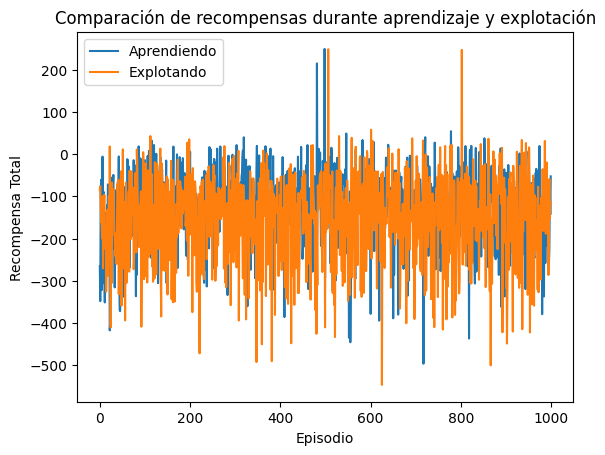

In [32]:
plt.plot(recompensa_episodios_aprendiendo, label='Aprendiendo')
plt.plot(recompensa_episodios_explotando, label='Explotando')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Comparación de recompensas durante aprendizaje y explotación')
plt.legend()
plt.show()

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [9]:
# Analizar los resultados aqui
